In [50]:
import os
os.environ['DGLBACKEND'] = 'mxnet'
import dgl
import networkx as nx
import mxnet as mx
from mxnet import gluon
import math
import numpy as np
import dgl.function as fn

In [2]:
def disjoint_chains(n_chains, length):
    path_graph = nx.path_graph(n_chains * length).to_directed()
    for i in range(n_chains - 1):  # break the path graph into N chains
        path_graph.remove_edge((i + 1) * length - 1, (i + 1) * length)
        path_graph.remove_edge((i + 1) * length, (i + 1) * length - 1)
    for n in path_graph.nodes:
        path_graph.add_edge(n, n)  # add self connections
    return path_graph

In [3]:
g1 = disjoint_chains(1, 30)
nx.draw(g1, pos=nx.circular_layout(g1))

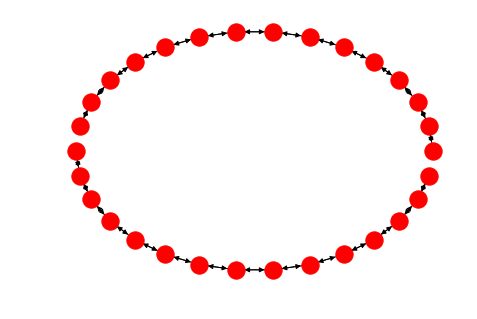

In [4]:
g2 = disjoint_chains(2, 15)
nx.draw(g2, pos=nx.circular_layout(g2))

In [110]:
n_train_samples = 500
n_epochs = 100
lr = 3e-2
weight_decay = 5e-4

g = dgl.DGLGraph(disjoint_chains(1, 1000), readonly=True)
labels = mx.nd.zeros([g.number_of_nodes()])
labels[mx.nd.arange(0, g.number_of_nodes(), 2)] = 1
#pattern = [0, 1]
#for i in range(int(g.number_of_nodes()/len(pattern))):
#    labels[i*len(pattern):(i + 1) * len(pattern)] = pattern

train_mask = mx.nd.zeros((g.number_of_nodes()))
train_mask[0:n_train_samples] = 1
eval_mask = mx.nd.zeros((g.number_of_nodes()))
eval_mask[n_train_samples:] = 1


def evaluate(pred, labels, mask):
    pred = pred.argmax(axis=1)
    accuracy = ((pred == labels) * mask).sum() / mask.sum().asscalar()
    return accuracy.asscalar()

# Helper function to convert a number 
# to its fixed width binary representation
def conv(x):
  a = format(x, '032b')
  l = list(str(a))
  l = np.array(list(map(int, l)))
  return l

## Here we predict with MLP

In [111]:
n_hidden = 16
n_classes = 2

class MLP(gluon.Block):
    def __init__(self,
                 n_hidden,
                 n_classes,
                 activation,):
        super(MLP, self).__init__()
        self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
        self.dense2 = gluon.nn.Dense(n_classes)

    def forward(self, features):
        h = features
        return self.dense2(self.dense1(h))
    
model = MLP(n_hidden, n_classes, 'relu')
model.initialize()
features = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
trainer = gluon.Trainer(model.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(10):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
print("loss: " + str(loss.asnumpy()) + ", acc: " + str(acc))

loss: [0.38786325], acc: 1.0


## Here we define a GCN model

In [112]:
class GCNLayer(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 out_feats,
                 activation):
        super(GCNLayer, self).__init__()
        self.g = g
        self.dense = gluon.nn.Dense(out_feats, activation=activation)

    def forward(self, h):
        self.g.ndata['h'] = h
        def concat_msg(edges):
            return {'m': edges.src['h']}
        def red_func(nodes):
            m = nodes.mailbox['m']
            if m.shape[1] == 3:
                h = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
            else:
                num_feats = m.shape[2]
                m = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(m, mx.nd.zeros(shape=(m.shape[0], num_feats)), dim=1)
            return {'h': self.dense(h)}
        self.g.update_all(concat_msg, red_func)
        return self.g.ndata.pop('h')

class GCN(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.layers = gluon.nn.Sequential()
        # input layer
        self.layers.add(GCNLayer(g, in_feats, n_hidden, activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.add(GCNLayer(g, n_hidden, n_hidden, activation))
        self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
        self.dense2 = gluon.nn.Dense(n_classes)

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return self.dense2(self.dense1(h))

In [113]:
degs = g.in_degrees().astype('float32')
norm = mx.nd.power(degs, -0.5)
g.ndata['norm'] = mx.nd.expand_dims(norm, 1)
features = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
model = GCN(g, in_feats=features.shape[1], n_hidden=16, n_classes=2, n_layers=3, activation='relu', dropout=0.5)
model.initialize()
trainer = gluon.Trainer(model.collect_params(), 'adam',
            {'learning_rate': lr, 'wd': weight_decay})

h = model(features)
loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(n_epochs):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
    print(acc)

/Users/dzzhen/Workspace/dgl/python/dgl/base.py:17: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


0.574
0.5
0.5
0.5
0.5
0.97
0.992
1.0
1.0
1.0
1.0
0.924
1.0
0.974
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## here we define an SSE model

In [30]:
class SteadyStateOperator(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(SteadyStateOperator, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(n_hidden)

    def forward(self, g):
        def apply_func(nodes):
            z = mx.nd.concat(nodes.data['x'], nodes.data['h'], dim=1)
            return {'h' : self.dense2(self.dense1(z))}

        g.ndata['xh'] = mx.nd.concat(g.ndata['x'], g.ndata['h'], dim=1)
        g.update_all(fn.copy_src(src='xh', out='m'), fn.sum(msg='m', out='h'))
        g.apply_nodes(apply_func)
        return g.ndata['h']

def update_embeddings(g, steady_state_operator):
    prev_h = g.ndata['h']
    next_h = steady_state_operator(g)
    g.ndata['h'] = (1 - alpha) * prev_h + alpha * next_h
    
class Predictor(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(Predictor, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(2)  ## binary classifier

    def forward(self, g):
        g.ndata['z'] = self.dense2(self.dense1(g.ndata['h']))
        return g.ndata['z']

In [36]:
n = g.number_of_nodes()
n_hidden = 16
n_embedding_updates = 1
n_parameter_updates = 1
alpha = 0.1
batch_size = 64
lr = 1e-2

g.ndata['x'] = mx.nd.eye(n, n)
#g.ndata['x'] = mx.nd.arange(n).reshape(n, 1)
g.ndata['h'] = mx.nd.random.normal(shape=(n, n_hidden))

steady_state_operator = SteadyStateOperator(n_hidden, 'relu')
steady_state_operator.initialize()
predictor = Predictor(n_hidden, 'relu')
predictor.initialize()
trainer = gluon.Trainer(predictor.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

def update_parameters(g, trainer):
    with mx.autograd.record():
        steady_state_operator(g)
        z = predictor(g)
        loss = loss_fcn(z, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
        print("loss: " + str(loss.asnumpy()))
    loss.backward()
    trainer.step(1)  # divide gradients by the number of labelled nodes
    return loss.asnumpy()[0]

def train(g, trainer):
     # first phase
    for i in range(n_embedding_updates):
        update_embeddings(g, steady_state_operator)
    # second phase
    for i in range(n_parameter_updates):
        loss = update_parameters(g, trainer)
    return loss

for epoch in range(1000):
    train(g, trainer)
    acc = evaluate(g.ndata['z'], labels, eval_mask)
    print(acc)

loss: [0.6931463]
0.502
loss: [0.69318914]
0.5
loss: [0.69314003]
0.5
loss: [0.69316196]
0.5
loss: [0.6931619]
0.5
loss: [0.6931418]
0.5
loss: [0.6931329]
0.5
loss: [0.6931399]
0.5
loss: [0.6931447]
0.5
loss: [0.6931384]
0.5
loss: [0.6931291]
0.5
loss: [0.69312483]
0.502
loss: [0.693126]
0.5
loss: [0.6931263]
0.5
loss: [0.6931217]
0.5
loss: [0.6931142]
0.5
loss: [0.6931089]
0.506
loss: [0.69310665]
0.5
loss: [0.69310296]
0.5
loss: [0.6930952]
0.5
loss: [0.6930856]
0.5
loss: [0.69307727]
0.502
loss: [0.6930696]
0.502
loss: [0.693059]
0.502
loss: [0.6930455]
0.502
loss: [0.69303125]
0.51
loss: [0.693018]
0.506
loss: [0.6930007]
0.502
loss: [0.6929805]
0.492
loss: [0.6929591]
0.52
loss: [0.69293666]
0.484
loss: [0.6929107]
0.51
loss: [0.69288164]
0.506
loss: [0.69285005]
0.516
loss: [0.6928142]
0.518
loss: [0.6927751]
0.508
loss: [0.692731]
0.506
loss: [0.69268185]
0.506
loss: [0.6926273]
0.51
loss: [0.69256693]
0.508
loss: [0.6925006]
0.502
loss: [0.6924272]
0.508
loss: [0.69234824]
0.50

loss: [0.68807584]
0.516
loss: [0.688073]
0.512
loss: [0.68807006]
0.508
loss: [0.6880639]
0.502
loss: [0.6880622]
0.508
loss: [0.6880641]
0.51
loss: [0.6880652]
0.504
loss: [0.68806773]
0.508
loss: [0.6880727]
0.512
loss: [0.6880766]
0.51
loss: [0.6880728]
0.508
loss: [0.68807155]
0.502
loss: [0.6880724]
0.504
loss: [0.6880741]
0.506
loss: [0.6880764]
0.51
loss: [0.68807226]
0.508
loss: [0.6880688]
0.508
loss: [0.6880647]
0.508
loss: [0.68806314]
0.506
loss: [0.6880638]
0.512
loss: [0.68806165]
0.506
loss: [0.6880604]
0.51
loss: [0.6880574]
0.506
loss: [0.68805677]
0.508
loss: [0.68805766]
0.504
loss: [0.68805796]
0.502
loss: [0.68805915]
0.508
loss: [0.6880576]
0.504
loss: [0.688057]
0.502
loss: [0.688056]
0.506
loss: [0.68805534]
0.506
loss: [0.68805736]
0.508
loss: [0.68805724]
0.502
loss: [0.68805754]
0.508
loss: [0.6880553]
0.506
loss: [0.6880541]
0.502
loss: [0.688053]
0.504
loss: [0.6880525]
0.506
loss: [0.6880556]
0.512
loss: [0.6880564]
0.506
loss: [0.68805766]
0.51
loss: [0.

0.504
loss: [0.6880483]
0.508
loss: [0.68804854]
0.504
loss: [0.68804944]
0.508
loss: [0.6880508]
0.506
loss: [0.68805164]
0.506
loss: [0.6880555]
0.504
loss: [0.6880576]
0.502
loss: [0.6880609]
0.512
loss: [0.68806046]
0.506
loss: [0.6880643]
0.508
loss: [0.688065]
0.514
loss: [0.688068]
0.506
loss: [0.68806505]
0.514
loss: [0.6880648]
0.51
loss: [0.68806]
0.506
loss: [0.68805814]
0.51
loss: [0.68805474]
0.506
loss: [0.6880537]
0.504
loss: [0.68805367]
0.502
loss: [0.6880538]
0.506
loss: [0.688056]
0.508
loss: [0.6880562]
0.502
loss: [0.6880585]
0.512
loss: [0.68805784]
0.502
loss: [0.6880592]
0.508
loss: [0.68805826]
0.506
loss: [0.68805856]
0.502
loss: [0.6880579]
0.508
loss: [0.68806]
0.504
loss: [0.68806094]
0.506
loss: [0.6880614]
0.504
loss: [0.6880604]
0.506
loss: [0.68805933]
0.504
loss: [0.6880575]
0.506
loss: [0.6880576]
0.504
loss: [0.68805903]
0.502
loss: [0.6880616]
0.512
loss: [0.68806064]
0.506
loss: [0.6880617]
0.508
loss: [0.6880585]
0.506
loss: [0.68805796]
0.508
los